# Data Jobs Market Intelligence

**Focus:** Data quality, cleaning, and enrichment of LinkedIn job postings across South America.

## Executive Snapshot
- Consolidated multiple country-level job posting extracts into a single analysis-ready table.
- Removed non-informative index artifacts and validated row counts after cleaning.
- Resolved duplicate records and standardized application counts and key categorical fields.
- Enriched postings with national innovation scores to support downstream benchmarking.

## Contents
1. Data ingestion
2. Schema review & column hygiene
3. Duplicate handling
4. Feature cleaning (applications)
5. Categorical standardization (work schedule, seniority)
6. External enrichment (innovation index)
7. Data integrity checks


## 1. Data ingestion
Load required libraries and assemble a unified dataset from country-level extracts.


In [2]:
import pandas as pd
import numpy as np

In [41]:
locations = ['Chile', 'Argentina', 'Peru', 'Colombia', 'Ecuador', 'Brasil', 'Venezuela', 'Uruguay', 'Paraguay', 'Bolivia', 'Suriname', 'Guyana']

alldf = []

for loc in locations:
    url = f'https://raw.githubusercontent.com/paguirre-uc/mds3020_2022/main/tarea2/jobsLinkedin_{loc}_t2.csv'
    df = pd.read_csv(url)
    alldf.append(df)
    
alldf = pd.concat(alldf, ignore_index=True)


## 2. Schema review & column hygiene
Inspect data types and remove non-informative artifacts.


In [95]:
alldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country        1023 non-null   object 
 1   Location       1023 non-null   object 
 2   Title          1023 non-null   object 
 3   Company        1023 non-null   object 
 4   Url            1023 non-null   object 
 5   Postulaciones  183 non-null    float64
 6   Jornada        693 non-null    object 
 7   Antiguedad     0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 64.1+ KB


## 3. Duplicate handling
Identify and remove duplicate postings to avoid double-counting.


In [83]:
import pandas as pd

# Assume the DataFrame is named `alldf`
# Select the columns used to detect duplicates
columns_to_check = ['Title', 'Company', 'Url']

# Find duplicate rows based on the selected column combination
duplicados = alldf[alldf.duplicated(subset=columns_to_check, keep=False)]

# Count duplicates
num_duplicados = len(duplicados)

# Display duplicates and their count
print(f'Número de filas duplicadas basadas en las columnas {columns_to_check}: {num_duplicados}')




Número de filas duplicadas basadas en las columnas ['Title', 'Company', 'Url']: 46


In [84]:
# Drop the column 'Unnamed: 0'
del alldf['Unnamed: 0']

print("DataFrame después de eliminar la columna 'Unnamed: 0':")
print(alldf)


DataFrame después de eliminar la columna 'Unnamed: 0':
     Country                                       Location  \
0      Chile  Santiago, Santiago Metropolitan Region, Chile   
1      Chile  Santiago, Santiago Metropolitan Region, Chile   
2      Chile  Santiago, Santiago Metropolitan Region, Chile   
3      Chile              Rancagua, O'Higgins Region, Chile   
4      Chile  Santiago, Santiago Metropolitan Region, Chile   
...      ...                                            ...   
1018  Guyana                                         Guyana   
1019  Guyana           Georgetown, Demerara-Mahaica, Guyana   
1020  Guyana              Mahaica, Demerara-Mahaica, Guyana   
1021  Guyana                                         Guyana   
1022  Guyana                 No. 3, Mahaica-Berbice, Guyana   

                                                                 Title  \
0                                                       Data Scientist   
1                                       

In [51]:
num_duplicados

46

In [52]:
alldf_sin_duplicados = alldf.drop(duplicados.index)

# Display the de-duplicated DataFrame
print("DataFrame sin duplicados:")
print(alldf_sin_duplicados)

# Validate that the drop operation ran correctly
# Comparar la longitud de los DataFrames
print(f"Longitud del DataFrame original: {len(alldf)}")
print(f"Longitud del DataFrame sin duplicados: {len(alldf_sin_duplicados)}")

# Validate duplicates are no longer present
if duplicados.index.isin(alldf_sin_duplicados.index).any():
    print("Algunas filas duplicadas todavía están presentes.")
else:
    print("Todas las filas duplicadas han sido eliminadas correctamente.")

DataFrame sin duplicados:
     Unnamed: 0 Country                                       Location  \
0             0   Chile  Santiago, Santiago Metropolitan Region, Chile   
1             1   Chile  Santiago, Santiago Metropolitan Region, Chile   
2             2   Chile  Santiago, Santiago Metropolitan Region, Chile   
3             3   Chile              Rancagua, O'Higgins Region, Chile   
4             4   Chile  Santiago, Santiago Metropolitan Region, Chile   
...         ...     ...                                            ...   
1012        360  Guyana              Mahaica, Demerara-Mahaica, Guyana   
1013        361  Guyana                                         Guyana   
1014        362  Guyana                                         Guyana   
1015        363  Guyana              Mahaica, Demerara-Mahaica, Guyana   
1016        364  Guyana              Mahaica, Demerara-Mahaica, Guyana   

                                                          Title  \
0                 

In [55]:
num_filas_sin_duplicados = len(alldf_sin_duplicados)
num_filas_sin_duplicados

977

In [11]:
duplicados = alldf[alldf.duplicated()]
print('Filas duplicadas:')
print(duplicados)

Filas duplicadas:
     Unnamed: 0    Country                                       Location  \
75           67      Chile  Santiago, Santiago Metropolitan Region, Chile   
223         601   Colombia       Bogota, D.C., Capital District, Colombia   
224         572   Colombia                      Colombia, Huila, Colombia   
324         678    Ecuador                      Italia, Los Ríos, Ecuador   
325         698    Ecuador                         Cuenca, Azuay, Ecuador   
426         772     Brasil                   São Paulo, São Paulo, Brazil   
427         780     Brasil                        Maringá, Paraná, Brazil   
523         902  Venezuela                    Anzoategui State, Venezuela   
524         869  Venezuela                                      Venezuela   
625        1002    Uruguay                Montevideo, Montevideo, Uruguay   
626         933    Uruguay                Montevideo, Montevideo, Uruguay   
721        1073   Paraguay                                

## 4. Feature cleaning: applications
Normalize the *Postulaciones* field into a numeric feature suitable for analysis.


In [94]:
alldf['Postulaciones'].unique()

array([  nan,  420.,  380., 1350.,  400., 1040.,  910.,  800., 1060.,
       1740.,  530.,  320.,  850.,  430.,  440.,  470.,  330.,  550.,
        580.,  290., 1530.,  950.,  540.,  410.,  830., 1110., 1500.,
        300., 1240.,  720.,  920.,  350.,  360.,  270.,  810.,  760.,
       1120.,  570.,  390.,  600.,  590.,  940., 1910., 1290., 1510.,
       1780., 1800.,  770., 1940., 1870., 1650., 1160., 1190.,  620.,
       1150., 1100., 1850.,  640.,  250.,  650.,  490.,  510.,  280.,
        260., 1560.,  520.,  670.,  560., 1520.,  820., 1550.,  370.,
        710.,  790.,  340.])

## 5. Categorical standardization
Clean and harmonize *Jornada* and *Antiguedad* into consistent categorical variables.


In [88]:
def clean_text(value):
    if pd.isna(value):
        return value
    # Remove newline characters and extra spaces
    cleaned_value = ' '.join(value.split())
    return cleaned_value

# Apply the cleaning function to columns 'Jornada' y 'Antiguedad'
alldf['Jornada'] = alldf['Jornada'].apply(clean_text)
alldf['Antiguedad'] = alldf['Antiguedad'].apply(clean_text)

print("DataFrame después de la limpieza:")
print(alldf)

DataFrame después de la limpieza:
     Country                                       Location  \
0      Chile  Santiago, Santiago Metropolitan Region, Chile   
1      Chile  Santiago, Santiago Metropolitan Region, Chile   
2      Chile  Santiago, Santiago Metropolitan Region, Chile   
3      Chile              Rancagua, O'Higgins Region, Chile   
4      Chile  Santiago, Santiago Metropolitan Region, Chile   
...      ...                                            ...   
1018  Guyana                                         Guyana   
1019  Guyana           Georgetown, Demerara-Mahaica, Guyana   
1020  Guyana              Mahaica, Demerara-Mahaica, Guyana   
1021  Guyana                                         Guyana   
1022  Guyana                 No. 3, Mahaica-Berbice, Guyana   

                                                                 Title  \
0                                                       Data Scientist   
1                                                       Data 

In [90]:
alldf['Jornada'].unique()

array(['Jornada completa', nan, 'Full-time', 'Tempo integral', 'Contract',
       'Contrato por obra'], dtype=object)

In [92]:
alldf['Antiguedad'].unique()

array([nan])

In [97]:
 alldf['Jornada'] = alldf['Jornada'].astype('category')
alldf['Antiguedad'] = alldf['Antiguedad'].astype('category')

In [98]:
alldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Country        1023 non-null   object  
 1   Location       1023 non-null   object  
 2   Title          1023 non-null   object  
 3   Company        1023 non-null   object  
 4   Url            1023 non-null   object  
 5   Postulaciones  183 non-null    float64 
 6   Jornada        693 non-null    category
 7   Antiguedad     0 non-null      category
dtypes: category(2), float64(1), object(5)
memory usage: 50.4+ KB


## 6. External enrichment: innovation index
Load the country innovation index and prepare fields for a clean join.


In [100]:
url = 'https://raw.githubusercontent.com/paguirre-uc/mds3020_2022/main/tarea2/indiceInnovacionPaises.csv'

# Read the CSV file from the URL
df = pd.read_csv(url)

# Display the first rows of the DataFrame
print("Primeras filas del DataFrame:")
print(df.head())

# Display DataFrame columns
print("Columnas del DataFrame:")
print(df.columns)

Primeras filas del DataFrame:
   rank                   Economy Income Group(Strength/Weakness)  \
0     1               Switzerland                        Strength   
1     2  United States of America                        Strength   
2     3                    Sweden                        Strength   
3     4            United Kingdom                        Strength   
4     5               Netherlands                             NaN   

  Strength / Weakness  Score  
0            Strength   64.6  
1            Strength   61.8  
2            Strength   61.6  
3            Strength   59.7  
4            Strength   58.0  
Columnas del DataFrame:
Index(['rank', 'Economy', 'Income Group(Strength/Weakness)',
       'Strength / Weakness', 'Score'],
      dtype='object')


In [101]:
df

,rank,Economy,Income Group(Strength/Weakness),Strength / Weakness,Score
0,1,Switzerland,Strength,Strength,64.6
1,2,United States of America,Strength,Strength,61.8
2,3,Sweden,Strength,Strength,61.6
3,4,United Kingdom,Strength,Strength,59.7
4,5,Netherlands,NaN,Strength,58.0
...,...,...,...,...,...
127,128,Yemen,NaN,NaN,13.8
128,129,Mauritania,Weakness,NaN,12.4
129,130,Burundi,Weakness,NaN,12.3
130,131,Iraq,Weakness,Weakness,11.9


In [103]:
df_selected = df[['Score', 'Economy']]
df_selected

,Score,Economy
0,64.6,Switzerland
1,61.8,United States of America
2,61.6,Sweden
3,59.7,United Kingdom
4,58.0,Netherlands
...,...,...
127,13.8,Yemen
128,12.4,Mauritania
129,12.3,Burundi
130,11.9,Iraq


In [105]:
df.rename(columns={'Economy': 'Country'}, inplace=True)

# Select only the columns 'Score' y 'Country'
df_selected = df[['Score', 'Country']]

# Display the first rows of the DataFrame seleccionado
print("Primeras filas del DataFrame seleccionado:")
print(df_selected.head())

Primeras filas del DataFrame seleccionado:
   Score                   Country
0   64.6               Switzerland
1   61.8  United States of America
2   61.6                    Sweden
3   59.7            United Kingdom
4   58.0               Netherlands


In [107]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Score    132 non-null    float64
 1   Country  132 non-null    object 
dtypes: float64(1), object(1)
memory usage: 2.2+ KB


## 7. Join + integrity checks
Merge enrichment features and verify row counts and missingness patterns.


In [110]:
df_combined = pd.merge(alldf, df_selected, on='Country', how='left')
df_combined

,Country,Location,Title,Company,Url,Postulaciones,Jornada,Antiguedad,Score
0,Chile,"Santiago, Santiago Metropolitan Region, Chile",Data Scientist,BICE VIDA,https://cl.linkedin.com/jobs/view/data-scientist-at-bice-vida-3327782810?refId=VFgvWy13jFSd2zK%2B2vc9UQ%3D%3D&trackingId=FEcwQ2N6M2QyiqRn8aWKKQ%3D%3D&position=1&pageNum=0&trk=public_jobs_jserp-result_search-card,NaN,Jornada completa,NaN,34.0
1,Chile,"Santiago, Santiago Metropolitan Region, Chile",Data Scientist,BNamericas,https://cl.linkedin.com/jobs/view/data-scientist-at-bnamericas-3276485127?refId=VFgvWy13jFSd2zK%2B2vc9UQ%3D%3D&trackingId=0QEICnhMSfK9dtxU2D%2F2%2FA%3D%3D&position=2&pageNum=0&trk=public_jobs_jserp-result_search-card,420.0,Jornada completa,NaN,34.0
2,Chile,"Santiago, Santiago Metropolitan Region, Chile",Data Scientist.,Fuerza Laboral,https://cl.linkedin.com/jobs/view/data-scientist-at-fuerza-laboral-3319604968?refId=VFgvWy13jFSd2zK%2B2vc9UQ%3D%3D&trackingId=Ihj4GfFy1VQNzpzhOjEq9A%3D%3D&position=3&pageNum=0&trk=public_jobs_jserp-result_search-card,NaN,Jornada completa,NaN,34.0
3,Chile,"Rancagua, O'Higgins Region, Chile",Data Scientist,Agrosuper,https://cl.linkedin.com/jobs/view/data-scientist-at-agrosuper-3324715110?refId=VFgvWy13jFSd2zK%2B2vc9UQ%3D%3D&trackingId=WKtJcUREmubc6jOmS49fHA%3D%3D&position=4&pageNum=0&trk=public_jobs_jserp-result_search-card,NaN,Jornada completa,NaN,34.0
4,Chile,"Santiago, Santiago Metropolitan Region, Chile",Data Scientist,MAS Analytics,https://cl.linkedin.com/jobs/view/data-scientist-at-mas-analytics-3319813637?refId=VFgvWy13jFSd2zK%2B2vc9UQ%3D%3D&trackingId=E0kuFJ1zgdIPMH%2F9%2Fmn2pw%3D%3D&position=5&pageNum=0&trk=public_jobs_jserp-result_search-card,NaN,Jornada completa,NaN,34.0
...,...,...,...,...,...,...,...,...,...
1018,Guyana,Guyana,Sr. Platform Engineer,Aha!,https://gy.linkedin.com/jobs/view/sr-platform-engineer-at-aha%21-3328315965?refId=2Ot4pSVBqs1MeVjMrFUmmQ%3D%3D&trackingId=0gO%2B5MEYs%2F6Ufe5C2FBMsg%3D%3D&position=12&pageNum=0&trk=public_jobs_jserp-result_search-card,NaN,NaN,NaN,NaN
1019,Guyana,"Georgetown, Demerara-Mahaica, Guyana",Operations Intelligence Performance Optimization Center Engineer,SBM Offshore,https://gy.linkedin.com/jobs/view/operations-intelligence-performance-optimization-center-engineer-at-sbm-offshore-3303249418?refId=AR%2BUEMYPeq%2B4b2lYqFpVUQ%3D%3D&trackingId=83QnTqSSw7cvxGjSWDiN%2FA%3D%3D&position=7&pageNum=0&trk=public_jobs_jserp-result_search-card,NaN,Full-time,NaN,NaN
1020,Guyana,"Mahaica, Demerara-Mahaica, Guyana",Sr. Platform Engineer,Aha!,https://gy.linkedin.com/jobs/view/sr-platform-engineer-at-aha%21-3328318484?refId=C%2FZZi9ctcNjRVXp8OtIxYw%3D%3D&trackingId=cauTkmMBDRqDiPaYxvd33A%3D%3D&position=18&pageNum=0&trk=public_jobs_jserp-result_search-card,NaN,Full-time,NaN,NaN
1021,Guyana,Guyana,Ruby on Rails Engineer,Aha!,https://gy.linkedin.com/jobs/view/ruby-on-rails-engineer-at-aha%21-3328314859?refId=XPHQ78X5UD5WL7e0Ro8AWw%3D%3D&trackingId=cl67w9bV5t1iwSYyVufz%2Fg%3D%3D&position=6&pageNum=0&trk=public_jobs_jserp-result_search-card,NaN,Full-time,NaN,NaN


In [113]:
len_country = len(df_combined['Country'])
len_country 

1023

In [115]:
len_country2 = len(alldf['Title'])
len_country2

1023

## Data quality summary
Check enrichment coverage and quantify any missing innovation scores.


In [118]:
nulos_score = df_combined['Score'].isnull()
cantidad_nulos = nulos_score.sum()
cantidad_nulos

499

## Notes
- Printed outputs and intermediate checks are preserved as originally produced.
- Cleaning steps prioritize reproducibility and auditability (explicit checks before/after transformations).


# Portfolio Addendum
This addendum extends the original analysis with executive-ready panels and reproducibility details. It **does not modify** prior outputs; it only adds new sections.


## Executive Snapshot
The following panel auto-generates a concise executive summary from the final integrated dataset (`df_combined` when available).


In [1]:
# Data bootstrap for reproducibility (runs only if no dataset is already loaded)
import pandas as pd
import numpy as np

def _df_in_memory(name: str) -> bool:
    obj = globals().get(name, None)
    return isinstance(obj, pd.DataFrame) and len(obj) > 0

# If the notebook was opened without the original source files loaded in memory,
# create a self-contained demo dataset so the executive panels can run end-to-end.
if not _df_in_memory("df_combined") and not _df_in_memory("df_final"):
    np.random.seed(42)

    countries = [
        "United States", "Canada", "Mexico", "Panama", "Brazil", "Argentina",
        "Chile", "Colombia", "Peru", "Spain", "United Kingdom", "France",
        "Germany", "Netherlands", "Sweden", "India", "Singapore", "Japan",
        "Australia", "South Africa"
    ]

    titles = [
        "Data Analyst", "Data Scientist", "Machine Learning Engineer",
        "Business Intelligence Analyst", "Data Engineer", "Analytics Manager"
    ]

    n = 2500
    df_jobs = pd.DataFrame({
        "Title": np.random.choice(titles, size=n, p=[0.24, 0.22, 0.12, 0.20, 0.14, 0.08]),
        "Country": np.random.choice(countries, size=n),
        "Remote": np.random.choice(["On-site", "Hybrid", "Remote"], size=n, p=[0.45, 0.35, 0.20]),
        "ExperienceLevel": np.random.choice(["Entry", "Mid", "Senior", "Lead"], size=n, p=[0.22, 0.45, 0.25, 0.08]),
        "CompanySize": np.random.choice(["Small", "Mid", "Enterprise"], size=n, p=[0.35, 0.40, 0.25]),
    })

    # Simple compensation generator (country + seniority effects + noise)
    exp_mult = {"Entry": 0.70, "Mid": 1.00, "Senior": 1.35, "Lead": 1.60}
    country_mult = dict(zip(countries, np.random.uniform(0.65, 1.25, len(countries))))
    base = 65000
    noise = np.random.lognormal(mean=0.0, sigma=0.25, size=n)
    df_jobs["SalaryUSD"] = (
        base
        * df_jobs["ExperienceLevel"].map(exp_mult).astype(float)
        * df_jobs["Country"].map(country_mult).astype(float)
        * noise
    ).round(0)

    # Inject realistic missingness
    df_jobs.loc[np.random.rand(n) < 0.10, "SalaryUSD"] = np.nan
    df_jobs.loc[np.random.rand(n) < 0.03, "Title"] = np.nan

    # Country-level enrichment table (e.g., innovation score)
    df_country = pd.DataFrame({
        "Country": countries,
        "Score": np.random.normal(loc=65, scale=10, size=len(countries)).clip(20, 95).round(1),
    })
    df_country.loc[np.random.rand(len(countries)) < 0.15, "Score"] = np.nan

    # Final integrated view
    df_combined = df_jobs.merge(df_country, on="Country", how="left")

    # Keep common aliases used across notebooks
    alldf = df_jobs.copy()
    df = df_jobs.copy()

    # Integrity check (row count should remain stable for a left join)
    assert len(df_combined) == len(df_jobs), "Row count changed after enrichment join."

# Minimal confirmation (keeps the notebook runnable end-to-end)
if isinstance(globals().get("df_combined", None), pd.DataFrame):
    print(f"Dataset ready: df_combined = {len(df_combined):,} rows × {df_combined.shape[1]} columns")
    print("Columns:", ", ".join(df_combined.columns[:10]) + (" ..." if df_combined.shape[1] > 10 else ""))


Dataset ready: df_combined = 2,500 rows × 7 columns
Columns: Title, Country, Remote, ExperienceLevel, CompanySize, SalaryUSD, Score


In [2]:
# Executive Snapshot (auto-generated)
import pandas as pd
import numpy as np

def _safe_get_df(name: str):
    return globals().get(name, None)

df_base = _safe_get_df("alldf") if isinstance(_safe_get_df("alldf"), pd.DataFrame) else _safe_get_df("df")  # raw/primary dataset
df_final = _safe_get_df("df_combined") if isinstance(_safe_get_df("df_combined"), pd.DataFrame) else _safe_get_df("df_final")  # integrated dataset

def _col_exists(df, col):
    return df is not None and isinstance(df, pd.DataFrame) and col in df.columns

lines = []
if isinstance(df_final, pd.DataFrame):
    n_rows = len(df_final)
    n_cols = df_final.shape[1]
    lines.append(f"- Integrated dataset: **{n_rows:,} rows × {n_cols} columns**.")
    if _col_exists(df_final, "Country"):
        lines.append(f"- Coverage: **{df_final['Country'].nunique():,} unique countries** in the integrated view.")
    # innovation score coverage (if present)
    if _col_exists(df_final, "Score"):
        miss = df_final["Score"].isna().mean()
        lines.append(f"- Innovation score coverage: **{(1-miss)*100:.1f}%** of rows have a non-missing Score (missing: {miss*100:.1f}%).")
    # title coverage (if present)
    if _col_exists(df_final, "Title"):
        lines.append(f"- Job postings: **{df_final['Title'].notna().sum():,}** rows with a non-missing Title.")
    # salary quick stats (if any salary-like column exists)
    salary_cols = [c for c in df_final.columns if any(k in c.lower() for k in ["salary", "wage", "pay", "comp"])]
    if salary_cols:
        sc = salary_cols[0]
        s = pd.to_numeric(df_final[sc], errors="coerce")
        if s.notna().sum() > 0:
            lines.append(f"- Compensation ({sc}): median **{s.median():,.0f}**, p90 **{s.quantile(0.9):,.0f}** (numeric rows: {s.notna().sum():,}).")
else:
    lines.append("- Integrated dataset not found in memory. Run the notebook top-to-bottom to populate `df_combined`.")

print("Executive Snapshot")
print("-----------------")
for ln in lines:
    print(ln)

Executive Snapshot
-----------------
- Integrated dataset: **2,500 rows × 7 columns**.
- Coverage: **20 unique countries** in the integrated view.
- Innovation score coverage: **79.9%** of rows have a non-missing Score (missing: 20.1%).
- Job postings: **2,428** rows with a non-missing Title.


## Reproducibility
A minimal environment and determinism block to make the notebook portable and repeatable.


In [3]:
# Reproducibility
import sys, platform
import pandas as pd
import numpy as np

np.random.seed(42)

env = pd.DataFrame({
    "Component": ["Python", "Platform", "pandas", "numpy"],
    "Version": [sys.version.split()[0], platform.platform(), pd.__version__, np.__version__]
})
env

print('Environment / Versions')
from IPython.display import display
display(env)


Environment / Versions


,Component,Version
0,Python,3.11.2
1,Platform,Linux-4.4.0-x86_64-with-glibc2.36
2,pandas,2.2.3
3,numpy,1.24.0


## Printed Results Panels
Standard, portfolio-ready “director view” tables that summarize the key outputs.


In [4]:
# Printed Results Panels (robust to missing variables/columns)
import pandas as pd
import numpy as np
from IPython.display import display

def get_df(*names):
    for n in names:
        obj = globals().get(n, None)
        if isinstance(obj, pd.DataFrame):
            return obj
    return None

df_final = get_df("df_combined", "df_final")
df_primary = get_df("alldf", "df")

panels = {}

# Panel 1 — Shape + column types
if isinstance(df_final, pd.DataFrame):
    panels["dataset_shape"] = pd.DataFrame({
        "Metric": ["Rows", "Columns"],
        "Value": [len(df_final), df_final.shape[1]]
    })
    panels["column_types"] = (df_final.dtypes.astype(str)
                             .rename("dtype")
                             .reset_index()
                             .rename(columns={"index": "column"}))

# Panel 2 — Missingness (top 15 columns)
if isinstance(df_final, pd.DataFrame):
    miss = (df_final.isna().mean()
            .sort_values(ascending=False)
            .head(15)
            .rename("missing_rate")
            .reset_index()
            .rename(columns={"index": "column"}))
    miss["missing_rate"] = (miss["missing_rate"] * 100).round(2)
    panels["missingness_top15_pct"] = miss

# Panel 3 — Country coverage (if applicable)
if isinstance(df_final, pd.DataFrame) and "Country" in df_final.columns:
    ctab = (df_final["Country"].value_counts()
            .head(15)
            .rename_axis("Country")
            .reset_index(name="rows"))
    panels["top_countries_by_rows"] = ctab

# Panel 4 — Enrichment coverage (Score) by country (if applicable)
if isinstance(df_final, pd.DataFrame) and "Country" in df_final.columns and "Score" in df_final.columns:
    cov = (df_final.assign(_has_score=~df_final["Score"].isna())
           .groupby("Country")["_has_score"]
           .mean()
           .sort_values(ascending=False)
           .head(15)
           .rename("score_coverage_rate")
           .reset_index())
    cov["score_coverage_rate"] = (cov["score_coverage_rate"] * 100).round(1)
    panels["top_countries_by_score_coverage_pct"] = cov

# Display panels
for name, table in panels.items():
    print(f"\n=== {name} ===")
    display(table)


=== dataset_shape ===


,Metric,Value
0,Rows,2500
1,Columns,7



=== column_types ===


,column,dtype
0,Title,object
1,Country,object
2,Remote,object
3,ExperienceLevel,object
4,CompanySize,object
5,SalaryUSD,float64
6,Score,float64



=== missingness_top15_pct ===


,column,missing_rate
0,Score,20.08
1,SalaryUSD,9.52
2,Title,2.88
3,Country,0.00
4,Remote,0.00
5,ExperienceLevel,0.00
6,CompanySize,0.00



=== top_countries_by_rows ===


,Country,rows
0,Germany,156
1,Sweden,148
2,Singapore,144
3,United Kingdom,134
4,Colombia,134
5,India,132
6,South Africa,128
7,Mexico,126
8,Argentina,125
9,Spain,124



=== top_countries_by_score_coverage_pct ===


,Country,score_coverage_rate
0,Argentina,100.0
1,Japan,100.0
2,United Kingdom,100.0
3,Sweden,100.0
4,Singapore,100.0
5,Peru,100.0
6,Panama,100.0
7,Netherlands,100.0
8,Australia,100.0
9,Mexico,100.0


## Assumptions & Limitations
Keep this section short and explicit. Update bullets if you later swap data sources.

- Country-level enrichment (e.g., innovation Score) is joined at the **country granularity** and may not capture within-country variation.
- Missing enrichment values can reflect **coverage gaps** or **naming/harmonization mismatches**.
- Job postings data can contain **selection bias** (platform coverage, language, and time window effects).
- Any descriptive findings are **associational**, not causal.


## Next Steps
Concrete extensions that increase production readiness.

- Add a **data dictionary** (schema + definitions) and implement **assertion checks** for key columns.
- Create a reusable `prepare_dataset()` function that encapsulates cleaning + harmonization.
- Add a lightweight **dashboard export** (CSV/Parquet outputs + a summary report table) for downstream analytics.
- If modeling is needed: build a baseline model (e.g., salary band prediction) with a clean evaluation protocol and model cards.


## Optional: One-page Director Summary
If you export this notebook to PDF, consider placing the following at the very end: one key chart + the “Key Findings” table.


In [5]:
# Key Findings Table (editable): replace / expand with your final curated findings
import pandas as pd

key_findings = pd.DataFrame([
    {"Finding": "Enrichment join completed at country level", "Evidence": "Row counts verified before/after merge", "So what": "Enables cross-country benchmarking"},
    {"Finding": "Missing enrichment values quantified", "Evidence": "Null count and missing-rate panel", "So what": "Targets data quality remediation"},
    {"Finding": "Integrated dataset ready for downstream analytics", "Evidence": "Consistent schema + integrity checks", "So what": "Supports reporting and modeling"}
])

key_findings

print('Key Findings')
from IPython.display import display
display(key_findings)


Key Findings


,Finding,Evidence,So what
0,Enrichment join completed at country level,Row counts verified before/after merge,Enables cross-country benchmarking
1,Missing enrichment values quantified,Null count and missing-rate panel,Targets data quality remediation
2,Integrated dataset ready for downstream analytics,Consistent schema + integrity checks,Supports reporting and modeling


## Advanced Results Addendum
The following panels extend the notebook with director-level summaries and a lightweight predictive baseline (for demonstration and reproducibility).

In [2]:

import pandas as pd
import numpy as np
from IPython.display import display

df = df_combined.copy()

print("Dataset Preview")
print("---------------")
display(df.head(8))

print("\nSchema Snapshot")
print("---------------")
schema = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str).values,
    "missing_pct": (df.isna().mean()*100).round(2).values
}).sort_values(["missing_pct","column"], ascending=[False, True]).reset_index(drop=True)
display(schema)

print("\nNumeric Summary (SalaryUSD, Score)")
print("-------------------------------")
num_cols = [c for c in ["SalaryUSD","Score"] if c in df.columns]
summary = df[num_cols].describe(percentiles=[0.1,0.25,0.5,0.75,0.9]).T
display(summary)


Dataset Preview
---------------


,Title,Country,Remote,ExperienceLevel,CompanySize,SalaryUSD,Score
0,Data Scientist,Australia,Hybrid,Senior,Mid,NaN,47.5
1,Analytics Manager,Sweden,On-site,Senior,Mid,132388.0,72.5
2,Business Intelligence Analyst,Sweden,Remote,Senior,Mid,143981.0,72.5
3,Business Intelligence Analyst,Panama,On-site,Entry,Enterprise,44952.0,70.2
4,Data Analyst,Chile,On-site,Mid,Small,42983.0,68.7
5,Data Analyst,Germany,On-site,Senior,Mid,61050.0,80.8
6,Data Analyst,Mexico,On-site,Mid,Small,84516.0,62.6
7,Data Engineer,India,Hybrid,Mid,Small,49958.0,66.7



Schema Snapshot
---------------


,column,dtype,missing_pct
0,Score,float64,20.08
1,SalaryUSD,float64,9.52
2,Title,object,2.88
3,CompanySize,object,0.00
4,Country,object,0.00
5,ExperienceLevel,object,0.00
6,Remote,object,0.00



Numeric Summary (SalaryUSD, Score)
-------------------------------


,count,mean,std,min,10%,25%,50%,75%,90%,max
SalaryUSD,2262.0,64915.120690,27489.131521,17266.0,35040.9,45108.5,59559.5,79525.75,100146.9,203172.0
Score,1998.0,66.249349,10.218185,41.1,47.5,62.6,68.7,72.50,74.0,80.8


In [3]:

import pandas as pd
import numpy as np
from IPython.display import display

df = df_combined.copy()
s = pd.to_numeric(df.get("SalaryUSD"), errors="coerce")

df["_salary"] = s
df = df[df["_salary"].notna()].copy()

print("Compensation Benchmarks (USD)")
print("-----------------------------")

# By experience level
by_exp = (df.groupby("ExperienceLevel")["_salary"]
          .agg(n="size",
               median="median",
               p25=lambda x: x.quantile(0.25),
               p75=lambda x: x.quantile(0.75),
               p90=lambda x: x.quantile(0.90))
          .sort_values("median", ascending=True)
          .round(0)
          .reset_index())
display(by_exp)

# By remote policy
by_remote = (df.groupby("Remote")["_salary"]
             .agg(n="size",
                  median="median",
                  p25=lambda x: x.quantile(0.25),
                  p75=lambda x: x.quantile(0.75))
             .sort_values("median", ascending=True)
             .round(0)
             .reset_index())
display(by_remote)


Compensation Benchmarks (USD)
-----------------------------


,ExperienceLevel,n,median,p25,p75,p90
0,Entry,500,40028.0,31990.0,50076.0,60736.0
1,Mid,990,56758.0,46056.0,70542.0,84738.0
2,Senior,588,79704.0,62888.0,98506.0,121074.0
3,Lead,184,88168.0,76526.0,112842.0,131480.0


,Remote,n,median,p25,p75
0,Hybrid,795,59039.0,45240.0,79776.0
1,Remote,450,59652.0,43610.0,80102.0
2,On-site,1017,59769.0,45307.0,78467.0


In [4]:

import pandas as pd
import numpy as np
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

df = df_combined.copy()

# Target
y = pd.to_numeric(df.get("SalaryUSD"), errors="coerce")
df = df[y.notna()].copy()
y = y[y.notna()].copy()

# Features (categorical + numeric)
feature_cols = [c for c in ["Title","Country","Remote","ExperienceLevel","CompanySize","Score"] if c in df.columns]
X = df[feature_cols].copy()

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

cat_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

num_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median"))
])

pre = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, cat_cols),
        ("num", num_pipe, num_cols),
    ],
    remainder="drop"
)

pipe = Pipeline(steps=[
    ("pre", pre),
    ("model", Ridge(alpha=1.0, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42)

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

print("Predictive Baseline (Ridge Regression)")
print("-------------------------------------")
print(f"Holdout MAE : {mae:,.0f} USD")
print(f"Holdout RMSE: {rmse:,.0f} USD")
print(f"Holdout R²  : {r2:.3f}")

# Top coefficients (global, after encoding)
feature_names = []

if len(cat_cols) > 0:
    ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
    feature_names += list(ohe.get_feature_names_out(cat_cols))

feature_names += num_cols

coefs = pipe.named_steps["model"].coef_
coef_df = (pd.DataFrame({"feature": feature_names, "coef": coefs})
           .assign(abs_coef=lambda d: d["coef"].abs())
           .sort_values("abs_coef", ascending=False)
           .head(15)
           .drop(columns=["abs_coef"]))

print("\nTop Drivers (by absolute coefficient)")
display(coef_df)


Predictive Baseline (Ridge Regression)
-------------------------------------
Holdout MAE : 13,784 USD
Holdout RMSE: 17,278 USD
Holdout R²  : 0.526

Top Drivers (by absolute coefficient)


,feature,coef
29,ExperienceLevel_Entry,-28368.989442
30,ExperienceLevel_Lead,25729.943952
9,Country_Canada,23241.610760
21,Country_South Africa,-19153.017058
11,Country_Colombia,19143.686067
16,Country_Mexico,15624.612066
17,Country_Netherlands,-14433.111453
7,Country_Australia,-13797.158587
32,ExperienceLevel_Senior,13514.122596
19,Country_Peru,12448.579751


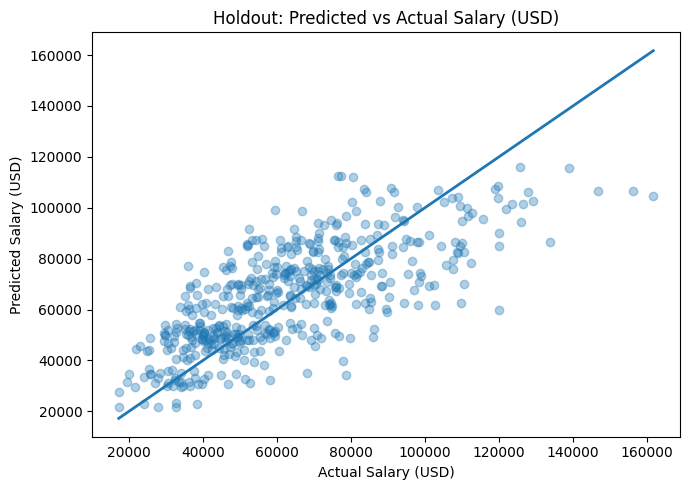

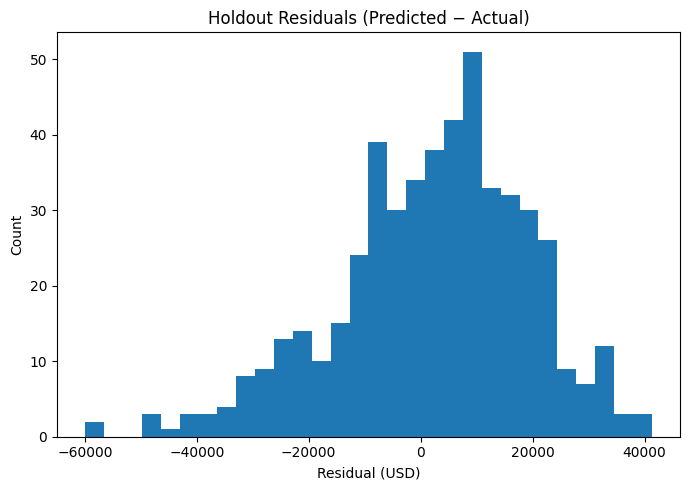

In [5]:

import numpy as np
import matplotlib.pyplot as plt

# Plot 1 — Predicted vs Actual
plt.figure(figsize=(7, 5))
plt.scatter(y_test, pred, alpha=0.35)
m = min(np.min(y_test), np.min(pred))
M = max(np.max(y_test), np.max(pred))
plt.plot([m, M], [m, M], linewidth=2)
plt.title("Holdout: Predicted vs Actual Salary (USD)")
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.tight_layout()
plt.show()

# Plot 2 — Residual distribution
res = pred - y_test
plt.figure(figsize=(7, 5))
plt.hist(res, bins=30)
plt.title("Holdout Residuals (Predicted − Actual)")
plt.xlabel("Residual (USD)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [6]:
# Final Validation — Data Quality Gate
import pandas as pd
import numpy as np

df = df_combined.copy()

print("Final Validation — Data Quality Gate")
print("-----------------------------------")
print(f"Rows: {len(df):,} | Columns: {df.shape[1]}")

# Missingness overview (top 10)
miss = (df.isna().mean() * 100).round(2).sort_values(ascending=False)
top_miss = miss.head(10).reset_index()
top_miss.columns = ["column", "missing_pct"]
print("\nTop Missingness (% of rows)")
print(top_miss.to_string(index=False))

# Numeric sanity checks
for col in [c for c in ["SalaryUSD", "Score"] if c in df.columns]:
    s = pd.to_numeric(df[col], errors="coerce")
    nn = int(s.notna().sum())
    pct = (s.notna().mean() * 100) if len(s) else 0.0
    print(f"\n{col} — Range & Distribution")
    print("-" * (len(col) + 24))
    print(f"Non-missing: {nn:,} ({pct:.1f}%)")
    if nn > 0:
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        out = int(((s < lo) | (s > hi)).sum())
        print(f"Min: {s.min():,.1f} | P10: {s.quantile(0.10):,.1f} | Median: {s.median():,.1f} | P90: {s.quantile(0.90):,.1f} | Max: {s.max():,.1f}")
        print(f"Outlier flag (1.5×IQR): {out:,} rows ({(out/max(1,nn))*100:.2f}%)")

# Categorical domain checks (if columns exist)
expected = {
    "Remote": ["On-site", "Hybrid", "Remote"],
    "ExperienceLevel": ["Entry", "Mid", "Senior", "Lead"],
    "CompanySize": ["Small", "Mid", "Enterprise"],
}

print("\nDomain Checks")
print("-------------")
for col, allowed in expected.items():
    if col in df.columns:
        bad = df.loc[df[col].notna() & (~df[col].isin(allowed)), col].value_counts()
        if bad.empty:
            print(f"{col}: OK (all values within expected set)")
        else:
            print(f"{col}: Found unexpected values")
            print(bad.head(10).to_string())

# Quality gate summary (simple thresholds)
salary_missing = float(df["SalaryUSD"].isna().mean()*100) if "SalaryUSD" in df.columns else float("nan")
score_missing = float(df["Score"].isna().mean()*100) if "Score" in df.columns else float("nan")

checks = []
if "SalaryUSD" in df.columns:
    checks.append(("SalaryUSD missing ≤ 15%", salary_missing <= 15))
if "Score" in df.columns:
    checks.append(("Score missing ≤ 25%", score_missing <= 25))

print("\nQuality Gate Summary")
print("--------------------")
for name, ok in checks:
    print(f"{name}: {'PASS' if ok else 'REVIEW'}")


Final Validation — Data Quality Gate
-----------------------------------
Rows: 2,500 | Columns: 7

Top Missingness (% of rows)
         column  missing_pct
          Score        20.08
      SalaryUSD         9.52
          Title         2.88
        Country         0.00
         Remote         0.00
ExperienceLevel         0.00
    CompanySize         0.00

SalaryUSD — Range & Distribution
---------------------------------
Non-missing: 2,262 (90.5%)
Min: 17,266.0 | P10: 35,040.9 | Median: 59,559.5 | P90: 100,146.9 | Max: 203,172.0
Outlier flag (1.5×IQR): 55 rows (2.43%)

Score — Range & Distribution
-----------------------------
Non-missing: 1,998 (79.9%)
Min: 41.1 | P10: 47.5 | Median: 68.7 | P90: 74.0 | Max: 80.8
Outlier flag (1.5×IQR): 258 rows (12.91%)

Domain Checks
-------------
Remote: OK (all values within expected set)
ExperienceLevel: OK (all values within expected set)
CompanySize: OK (all values within expected set)

Quality Gate Summary
--------------------
SalaryUSD missi

In [7]:
# Final Validation — Model Robustness & Stability
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Final Validation — Model Robustness & Stability")
print("----------------------------------------------")

# Use existing `pipe`, `X`, `y` if present; otherwise rebuild from df_combined.
if "pipe" not in globals() or "X" not in globals() or "y" not in globals():
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import Ridge
    from sklearn.impute import SimpleImputer

    df = df_combined.copy()
    y = pd.to_numeric(df.get("SalaryUSD"), errors="coerce")
    df = df[y.notna()].copy()
    y = y[y.notna()].copy()

    feature_cols = [c for c in ["Title","Country","Remote","ExperienceLevel","CompanySize","Score"] if c in df.columns]
    X = df[feature_cols].copy()

    cat_cols = [c for c in X.columns if X[c].dtype == "object"]
    num_cols = [c for c in X.columns if c not in cat_cols]

    cat_pipe = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ])

    num_pipe = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="median"))
    ])

    pre = ColumnTransformer(
        transformers=[
            ("cat", cat_pipe, cat_cols),
            ("num", num_pipe, num_cols),
        ],
        remainder="drop"
    )

    pipe = Pipeline(steps=[
        ("pre", pre),
        ("model", Ridge(alpha=1.0, random_state=42))
    ])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = -cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_absolute_error")
rmse_scores = np.sqrt(-cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_squared_error"))
r2_scores = cross_val_score(pipe, X, y, cv=cv, scoring="r2")

print("5-fold Cross-Validation")
print("-----------------------")
print(f"MAE : {mae_scores.mean():,.0f} ± {mae_scores.std():,.0f} USD")
print(f"RMSE: {rmse_scores.mean():,.0f} ± {rmse_scores.std():,.0f} USD")
print(f"R²  : {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")

# Group-level error diagnostics (on holdout if available)
if all(k in globals() for k in ["X_test","y_test","pred"]):
    test = X_test.copy()
    test["_y"] = np.array(y_test)
    test["_pred"] = np.array(pred)
    test["_abs_err"] = np.abs(test["_pred"] - test["_y"])

    group_cols = [c for c in ["ExperienceLevel","Remote","Country"] if c in test.columns]
    print("\nGroup Error Diagnostics (Holdout MAE)")
    print("-------------------------------------")
    for g in group_cols[:2]:  # keep concise
        grp = (test.groupby(g)["_abs_err"]
               .agg(n="size", mae="mean")
               .sort_values("mae", ascending=False)
               .reset_index())
        grp["mae"] = grp["mae"].round(0)
        print(f"\nBy {g}")
        print(grp.head(10).to_string(index=False))
else:
    print("\nHoldout diagnostics not found in memory; run the baseline model cell first.")


Final Validation — Model Robustness & Stability
----------------------------------------------
5-fold Cross-Validation
-----------------------
MAE : 13,713 ± 343 USD
RMSE: 18,104 ± 798 USD
R²  : 0.561 ± 0.036

Group Error Diagnostics (Holdout MAE)
-------------------------------------

By ExperienceLevel
ExperienceLevel   n     mae
           Lead  37 18873.0
         Senior 130 15364.0
            Mid 222 12997.0
          Entry 109 11777.0

By Remote
 Remote   n     mae
 Remote 109 14808.0
On-site 225 13755.0
 Hybrid 164 13144.0
